# Timeseries Survival Analysis Tutorial

This notebook aims to demonstrate how to perform survival analysis in the context of PV assets, using the methodology from https://ieeexplore.ieee.org/document/9272625/. As outlined in that paper, survival analysis is concerned with estimating the failure rate over the lifetime of a system, given discrete observed failure events.

Gunda et al. used two methods: Kaplan-Meier estimation and fitting a Weibull distribution. We will do both here.

__TO BE CHANGED__

In [1]:
import pandas as pd
from sksurv.nonparametric import kaplan_meier_estimator
from scipy import stats
import matplotlib.pyplot as plt

## Loading and preprocessing data

### Reading in data

We read in the data below, where each column reflects data from an O&M (operation and maintenance) ticket. Note the following column descriptions:

- `randid` is an integer identifying the PV site

- `COD` identifies the commissioning date of the site

- `EventStart` is the recorded time of the event

- `Asset` identifies the asset involved in the event

In [2]:
om_df = pd.read_csv('example_data/example_om_survival_analysis_data.csv')
om_df.head(5)

,randid,COD,EventStart,Asset
0,0,2015-09-24,2016-05-18 09:00:00,Other
1,1,2014-08-01,2016-06-13 09:00:00,Other
2,2,2011-12-27,2016-11-10 09:00:00,Other
3,3,2015-07-22,2016-11-10 09:00:00,Other
4,4,2015-08-13,2016-11-24 09:00:00,Other


For later use, so we can identify all of the unique assets and randids below:

In [3]:
assets = om_df['Asset'].unique()
randids = om_df['randid'].unique()
assets, randids

(array(['Other', 'Transformer', 'Inverter', 'Tracker', 'Facility',
        'Combiner'], dtype=object),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158

### Data processing

As a first step, we can calculate the days until the event was observed.

In [4]:
om_df['days_until_failure'] = (pd.to_datetime(om_df['EventStart']) - pd.to_datetime(om_df['COD'])).dt.days

Without knowing more about the nature of the observed events, we will only consider the first event for a given asset type for each site. We can construct a dataframe that represents all of these "first failures" for each asset-site pair. We set the `was_observed` column to `True` to indicate that these observations were in our dataset.

In [5]:
first_fails_df = om_df.groupby(['randid','Asset']).first()
first_fails_df['was_observed'] = True
first_fails_df.head(5)

,,COD,EventStart,days_until_failure,was_observed
randid,Asset,,,,
0,Other,2015-09-24,2016-05-18 09:00:00,237,True
1,Other,2014-08-01,2016-06-13 09:00:00,682,True
2,Other,2011-12-27,2016-11-10 09:00:00,1780,True
3,Other,2015-07-22,2016-11-10 09:00:00,477,True
4,Other,2015-08-13,2016-11-24 09:00:00,469,True


If a given asset-site pair did not experience a recorded event, it is not reflected explicitly in our dataset. However, we do have (implicit) information about it: we know that no failures occurred until _at least_ the last recorded event for that site. The name for this type of data is _right-censored data_, as we know failures only occurred to right of (after) a known time.

Therefore, we can construct a second dataframe with the last recorded event (of any type) for each site. This gives us a largest observable value for `days_until_failure` for each site. If we didn't observe an event with a specific asset-site pair, we will default to this largest observable value. We set `was_observed` to `False` to indicate that this event was _censored_.

In [6]:
last_fails_df = om_df.groupby('randid').last().drop(columns=['Asset']) # we don't care about the asset here
last_fails_df['was_observed'] = False
last_fails_df.head(5)

,COD,EventStart,days_until_failure,was_observed
randid,,,,
0,2015-09-24,2018-10-21 09:00:00,1123,False
1,2014-08-01,2018-10-08 09:00:00,1529,False
2,2011-12-27,2018-08-27 09:00:00,2435,False
3,2015-07-22,2018-05-22 09:00:00,1035,False
4,2015-08-13,2018-10-02 09:00:00,1146,False


Now we can construct a new dataframe whose index contains every unique combination of site and asset. We then pre-fill the dataframe with the data from `last_fails_df` before replacing any rows that were found in `all_sites_assets_df` with the uncensored data.

The result is that we have a row for every site-asset pair, where if at least one relevant event was in our dataset, we have the time to failure until the first such event. Meanwhile, if there were no relevant events in the dataset, we have the latest time at which we knew a failure hadn't yet occurred. The `was_observed` column tells us whether it was an observed datapoint or a censored one.

In [7]:
# initialize dataframe with a row for every unique site-asset pair
all_sites_assets_df = pd.DataFrame(index=pd.MultiIndex.from_product([randids, assets], names=['randid', 'Asset']),
                                   columns=first_fails_df.columns,
                                   dtype=first_fails_df.dtypes.values)

# prefill dataframe with the last possible times (the censored times)
for randid in randids:
    all_sites_assets_df.loc[(randid, slice(None)), :] = last_fails_df.loc[randid].values

# for every row that did have a recorded event, replace the censored time with the observed one
all_sites_assets_df.loc[first_fails_df.index] = first_fails_df

# set the column dtypes appropriately
all_sites_assets_df = all_sites_assets_df.astype(first_fails_df.dtypes)

all_sites_assets_df.head(10)

COD           EventStart  days_until_failure  \
randid Asset                                                              
0      Other        2015-09-24  2016-05-18 09:00:00                 237   
       Transformer  2015-09-24  2018-10-21 09:00:00                1123   
       Inverter     2015-09-24  2018-10-21 09:00:00                1123   
       Tracker      2015-09-24  2018-10-21 09:00:00                1123   
       Facility     2015-09-24  2018-10-21 09:00:00                1123   
       Combiner     2015-09-24  2018-10-21 09:00:00                1123   
1      Other        2014-08-01  2016-06-13 09:00:00                 682   
       Transformer  2014-08-01  2018-10-08 09:00:00                1529   
       Inverter     2014-08-01  2018-10-08 09:00:00                1529   
       Tracker      2014-08-01  2018-10-08 09:00:00                1529   

                    was_observed  
randid Asset                      
0      Other                True  
       Transformer         False  
       Inverter            False  
       Tracker             False  
       Facility            False  
       Combiner            False  
1      Other                True  
       Transformer         False  
       Inverter            False  
       Tracker             False

Now we are ready to perform survival analysis on the data.

## Failure probability estimation

### Kaplan-Meier estimator

The Kaplan-Meier estimator is a nonparametric estimator, which means it does not assume a particular form for the failure probability distribution. This makes it more flexible and potentially more accurrate than parametric methods.

Note that the Kaplan-Meier estimator is used to estimate the _survival function_, which is the probability of __not__ observing a failure before a point in time. We are interested in the opposite probability, the probability that at least one failure has occured before a point in time. To get this, we just subtact the survival function probability from 1.

#### Computation

Now, we are ready to estimate the probability of failure over time for each asset using the Kaplan-Meier estimator of the survival function. `scikit-survival` has an implementation of the estimator: `kaplan_meier_estimator(event, time_exit)`, where
- `event` denotes whether each event was observed
- `time_exit` denotes the time observed until each observation exited the study, either by a failure or via censoring

By including the optional keyword argument `conf_type='log-log'`, we can also obtain an estimate of the 95% confidence interval of the Kaplan-Meier estimator.

Note the Kaplan-Meier estimator is for the survival function. By subtracting it from 1, we get the probability of the first failure of the asset having occured by a point in time.

In [8]:
kaplan_meier_results = {}
for asset in assets:
    asset_df = all_sites_assets_df.loc[(slice(None), asset), :]
    times, surv_func, conf_int = kaplan_meier_estimator(asset_df['was_observed'],
                                                        asset_df['days_until_failure'],
                                                        conf_type='log-log')
    kaplan_meier_results[asset] = {'times' : times,
                                   'fail_prob' : 100 * (1 - surv_func),
                                   'upper' : 100 * (1 - conf_int[0]),
                                   'lower' : 100 * (1 - conf_int[1])}

#### Plotting

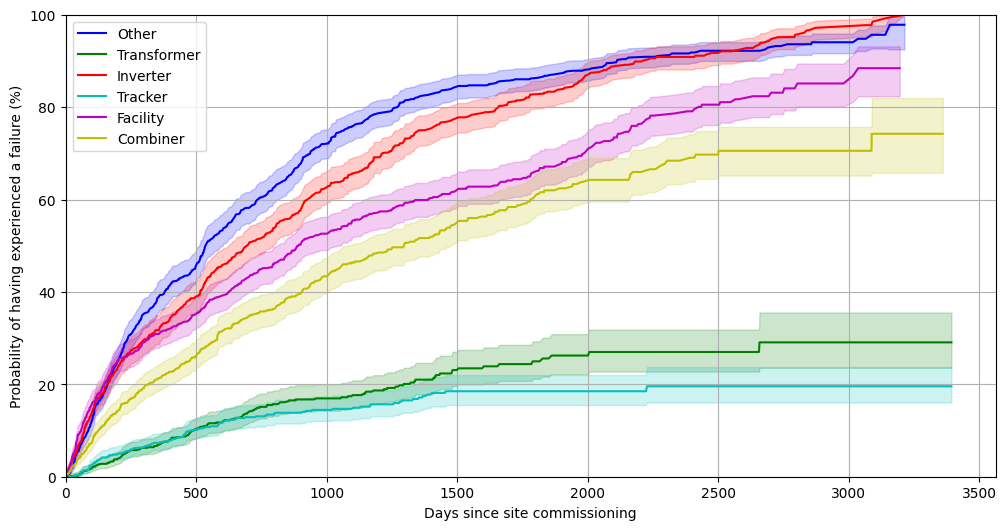

In [9]:
plt.figure(figsize=(12,6))
colors = list(plt.cm.colors.BASE_COLORS.values())[:len(assets)]

for asset, color in zip(assets, colors):
    result = kaplan_meier_results[asset]
    plt.plot(result['times'], result['fail_prob'], color=color, label=asset)
    plt.fill_between(result['times'], result['lower'], result['upper'], color=color, alpha=0.2)

plt.legend();
plt.grid();
plt.xlim(0,None);
plt.ylim(0,100);
plt.xlabel('Days since site commissioning')
plt.ylabel('Probability of having experienced a failure (%)');

### Weibull distribution fitting

The Weibull distribution describes a family of probability distributions parametrized by a _shape_ parameter and a _scale_ parameter. It is frequently used to model the probability of failure by fitting its parameters to observed data. As a parametric method, it is less flexible than the nonparametric Kaplan-Meier estimation but can still be useful.

#### Computation

`scipy` implements the Weibull distribution via `stats.weibull_min`, but before that we must first construct a `stats.CensoredData` object from our data.

To create a `stats.CensoredData` object, we simply pass in an array containing our uncensored times using the `uncensored` keyword, and similarly, we pass in an array contianing our right-censored times using the `right` keyword. Then we just pass the result into `stats.weibull.fit()` to fit the _scale_ and _shape_ parameters.

Note that `scipy` also implements a `loc` parameter for all of its distributions. We want to fix this to zero for our application, so we simply add `floc=0` in our call to `stats.weibull_min.fit`.

In [ ]:
weibull_results = {}
for asset in assets:
    asset_df = all_sites_assets_df.loc[(slice(None), asset), :]
    uncensored_times = asset_df[asset_df['was_observed']]['days_until_failure']
    censored_times = asset_df[~asset_df['was_observed']]['days_until_failure']
    data = stats.CensoredData(uncensored=uncensored_times, right=censored_times)

    shape, _, scale = stats.weibull_min.fit(data, floc=0)
    weibull_results[asset] = {'shape' : shape, 'scale' : scale}

#### Plotting

To plot the results, we simply pass our parameters into `stats.weibull_min()` and call its `cdf()` function. Note that `scipy` calls the shape parameter `c` and the scale parameter `scale`.

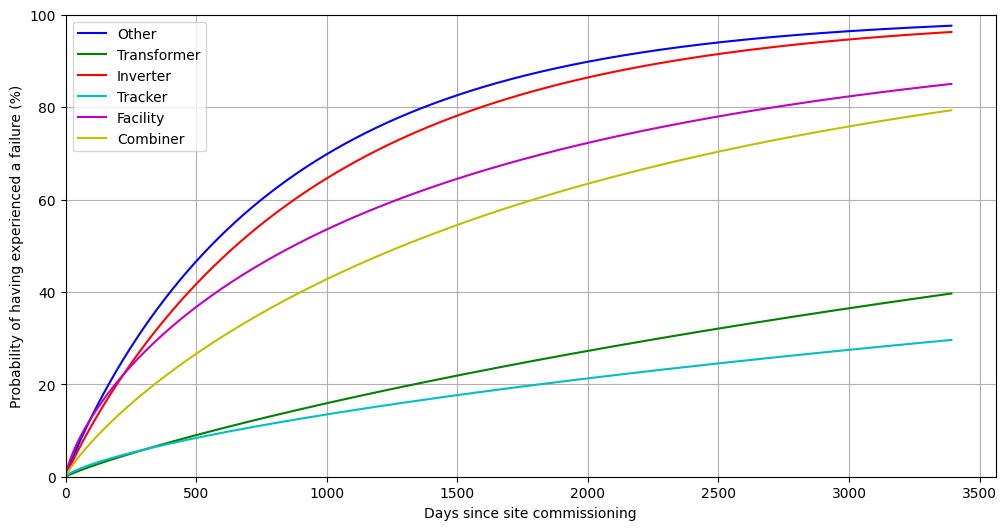

In [24]:
plt.figure(figsize=(12,6))
colors = list(plt.cm.colors.BASE_COLORS.values())[:len(assets)]
days = range(all_sites_assets_df['days_until_failure'].max())

for asset, color in zip(assets, colors):
    fitted_weibull = stats.weibull_min(c=weibull_results[asset]['shape'],
                                       scale=weibull_results[asset]['scale'])
    weibull_probs = 100 * fitted_weibull.cdf(days)
    plt.plot(days, weibull_probs, color=color, label=asset)

plt.legend();
plt.grid();
plt.xlim(0,None);
plt.ylim(0,100);
plt.xlabel('Days since site commissioning')
plt.ylabel('Probability of having experienced a failure (%)');